# Time Series Analysis of the US Treasury 10-Year Yield

We follow the standard workflow of time series analysis in Python:

* Extract time series from FRED with Pandas
* Clean, tidy and transform the dataset
* do statistical descriptive analysis of the dataset
* detect the common trend or anomalies by ploting the time series
* Fit the model and check the fittness of the model
* Interpret the model with economic theories

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels.compat import lzip

In [2]:
# extract time series
# DGS strands for Treasury rate at constant maturity rate
symbols = ['DGS3MO', 'DGS1', 'DGS5', 'DGS10', 'DAAA', 'DBAA', 'DCOILWTICO']
start_date = '2000-01-01'
end_date = '2013-05-31'

In [4]:
def get_exchange_data(symbols, start_date, end_date):
    data = pdr.fred.FredReader(symbols, start_date, end_date).read().dropna()
    data = data.rename_axis(None)
    return data

In [5]:
treasury_raw = get_exchange_data(symbols, start_date, end_date)
treasury_raw.head()

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
2000-01-04,5.43,6.00,6.40,6.49,7.69,8.21,25.56
2000-01-05,5.44,6.05,6.51,6.62,7.78,8.29,24.65
2000-01-06,5.41,6.03,6.46,6.57,7.72,8.24,24.79
2000-01-07,5.38,6.00,6.42,6.52,7.69,8.22,24.79
2000-01-10,5.42,6.07,6.49,6.57,7.72,8.27,24.71


In [6]:
treasury_raw.tail()

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
2013-05-24,0.04,0.12,0.90,2.01,3.94,4.76,93.84
2013-05-28,0.05,0.13,1.02,2.15,4.06,4.88,94.65
2013-05-29,0.05,0.14,1.02,2.13,4.04,4.88,93.13
2013-05-30,0.04,0.13,1.01,2.13,4.06,4.90,93.57
2013-05-31,0.04,0.14,1.05,2.16,4.09,4.95,91.93


<AxesSubplot:>

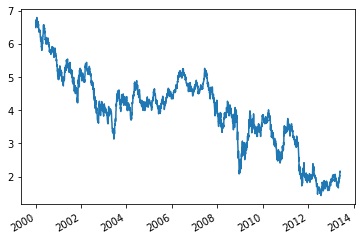

In [7]:
# plot dgs10
# our focus is on DGS10, the yield of constant-maturity 10 year US bond
treasury_raw['DGS10'].plot()

In [9]:
# transform the dataset by creating weekly and monthly time series
dgs10_daily = treasury_raw['DGS10']

In [10]:
dgs10_weekly = dgs10_daily.resample('W').ffill()
dgs10_weekly.head()

2000-01-09    6.52
2000-01-16    6.69
2000-01-23    6.79
2000-01-30    6.66
2000-02-06    6.53
Freq: W-SUN, Name: DGS10, dtype: float64

In [11]:
dgs10_monthly = dgs10_daily.resample("M").ffill()
dgs10_monthly.head()

2000-01-31    6.68
2000-02-29    6.42
2000-03-31    6.03
2000-04-30    6.23
2000-05-31    6.29
Freq: M, Name: DGS10, dtype: float64

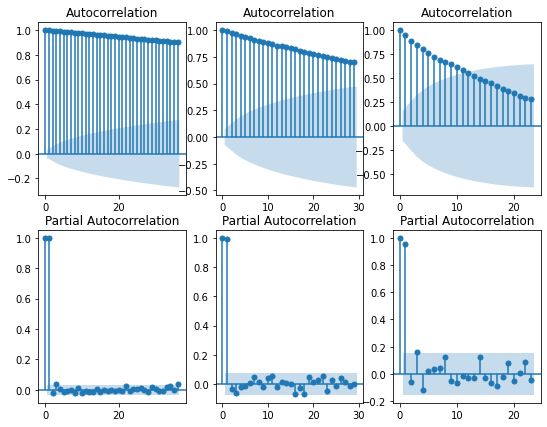

In [16]:
# The ACF and PACF for daily, weekly and monthly series
series = [dgs10_daily, dgs10_weekly, dgs10_monthly]
fig, axes = plt.subplots(2, 3, figsize=(9, 7))
axes = axes.flatten()
for n, sr in enumerate(series):
    sm.graphics.tsa.plot_acf(sr, ax = axes[n])
    sm.graphics.tsa.plot_pacf(sr, ax=axes[n+3])

## Unit Root

The first order autoregressive model, $y_t = a_1 y_{t-1} + \epsilon_t$ has a unit root when $a_1 = 1$. In this example, the characteristic equation $m-a_1= 0$. The root of the equation is $m=1$. If the process has a unit root, then it is a non-stationary time series. That is, the moments of the stochastic process depend on t. 

For instance, the first order unit root process, can be written as 
$$y_t = y_0 + \sum_{j=1}^t \epsilon_t$$. Then the variance of $y_t$ is given by
$$Var(y_t) = t\sigma^2$$

The rule of model selection:

| Coefficients |  | MA(q)                   | AR(p) | ARMA(p, q) |
|-------|-------------|----------------------------|----|---|
| $\rho_s$     | ACF    | truncated after q lags |  dies out slowly  | dies out slowly   |
| $\phi_{ss}$    | PACF        | dies out slowly      | truncated after p lags   |  dies out slowly  |

 The high first-order auto-correlation suggests that the time series has a unit root on every periodicity (daily, weekly and monthly).

In [22]:
# do the unit test
# H0: there is a unit root
# H1: stationary process
stats_description = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical values', 'ictest']
lzip(stats_description, sm.tsa.stattools.adfuller(dgs10_daily))  # it is not stationary

[('adf', -1.938280948862017),
 ('pvalue', 0.31427227105122324),
 ('usedlag', 2),
 ('nobs', 3336),
 ('critical values',
  {'1%': -3.432311732287807,
   '5%': -2.8624067784120184,
   '10%': -2.5672314034851254}),
 ('ictest', -8900.520216104167)]

In [23]:
lzip(stats_description, sm.tsa.stattools.adfuller(dgs10_weekly))

[('adf', -1.9139324476329165),
 ('pvalue', 0.3255355002586324),
 ('usedlag', 0),
 ('nobs', 699),
 ('critical values',
  {'1%': -3.439739809554328,
   '5%': -2.86568368980381,
   '10%': -2.5689766074363334}),
 ('ictest', -840.5639271729201)]

In [24]:
lzip(stats_description, sm.tsa.stattools.adfuller(dgs10_monthly))

[('adf', -1.0934950089766249),
 ('pvalue', 0.7176590364405535),
 ('usedlag', 7),
 ('nobs', 153),
 ('critical values',
  {'1%': -3.473829775724492,
   '5%': -2.880622899711496,
   '10%': -2.5769448985432954}),
 ('ictest', 45.70209897226903)]

In [26]:
# adf test for the first-differenced series
lzip(stats_description, sm.tsa.stattools.adfuller(dgs10_daily.diff().dropna()))

[('adf', -42.9597525221356),
 ('pvalue', 0.0),
 ('usedlag', 1),
 ('nobs', 3336),
 ('critical values',
  {'1%': -3.432311732287807,
   '5%': -2.8624067784120184,
   '10%': -2.5672314034851254}),
 ('ictest', -8894.840417053736)]

In [27]:
# adf test for the first-differenced series
lzip(stats_description, sm.tsa.stattools.adfuller(dgs10_weekly.diff().dropna()))

[('adf', -17.867386456522432),
 ('pvalue', 3.0368778926764357e-30),
 ('usedlag', 1),
 ('nobs', 697),
 ('critical values',
  {'1%': -3.439766853257416,
   '5%': -2.8656956054873377,
   '10%': -2.5689829557089308}),
 ('ictest', -837.295752407631)]

In [28]:
# the ADF test rejects the null hypothesis that a unit root is present for the
# first-differenced series

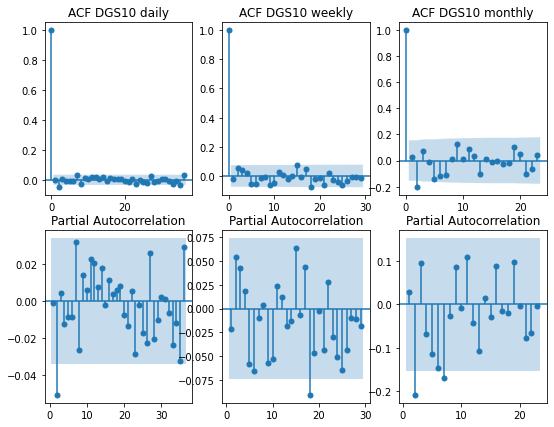

In [41]:
# The ACF and PACF for daily, weekly and monthly differenced series
series = [dgs10_daily, dgs10_weekly, dgs10_monthly]
freq = ['daily', 'weekly', 'monthly']
fig, axes = plt.subplots(2, 3, figsize=(9, 7))
axes = axes.flatten()
for n, sr in enumerate(series):
    sm.graphics.tsa.plot_acf(sr.diff().dropna(), ax = axes[n], title='ACF '+sr.name+ ' '+freq[n])
    sm.graphics.tsa.plot_pacf(sr.diff().dropna(), ax=axes[n+3], zero=False)

The apparent time series structure of DGS10 varies with the periodicity:

Daily:

* strong negative order-2 autocorrelation and partial autocorrelation
* strong positive order-7 autocorrelation and partial autocorrelation

Weekly:

* weak time series structure; possible significant correlations at lag 15 (simple) and lag 18 (partial)

Monthly:

* strong negative order-2 autocorrelation (both simple and partial)

The autocorrelations are modestly larger as the periodicity increases
from daily to weekly to monthly.

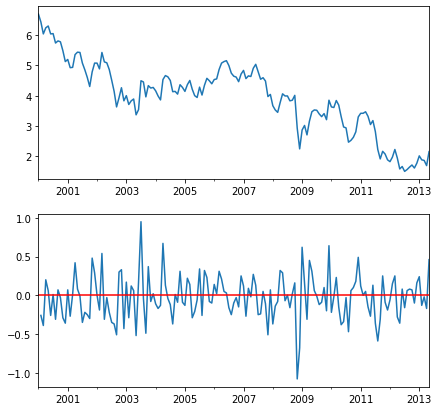

In [47]:
# plot monthly data
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
dgs10_monthly.plot(ax=axes[0])
dgs10_monthly.diff().plot(ax=axes[1])
axes[1].axhline(y=0, color='r')

In [51]:
# fit the AR(2) model
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(dgs10_monthly, lags=2).fit()

/Users/Michael/.virtualenvs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [53]:
res.params

intercept    0.129382
DGS10.L1     1.006741
DGS10.L2    -0.046125
dtype: float64

In [54]:
res.pvalues

intercept    1.042324e-01
DGS10.L1     1.434113e-36
DGS10.L2     5.604832e-01
dtype: float64

In [56]:
# return the complex roots of ar(2)
res.roots  # they are outside the unit circle

array([ 1.04316051, 20.78338343])

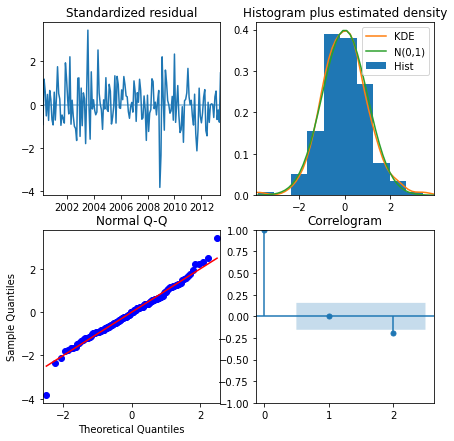

In [60]:
fig=res.plot_diagnostics(lags=2, figsize=(7, 7))

No handles with labels found to put in legend.


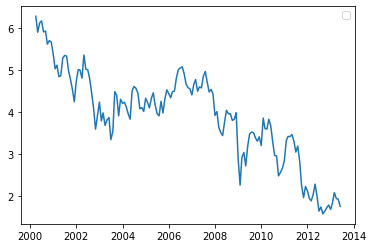

In [61]:
fig = res.plot_predict()

In [62]:
# fit lags = 7 
res = AutoReg(dgs10_monthly, lags=7).fit()

/Users/Michael/.virtualenvs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


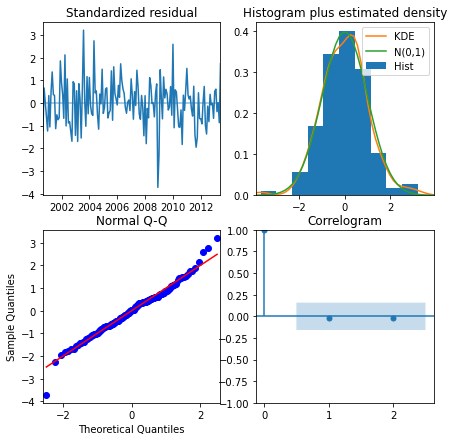

In [63]:
fig=res.plot_diagnostics(lags=2, figsize=(7, 7))

In [64]:
res.roots

array([ 1.02289125-0.j        ,  1.06561239-0.73778337j,
        1.06561239+0.73778337j, -0.15505524-1.3188812j ,
       -0.15505524+1.3188812j , -1.24595533-0.91220477j,
       -1.24595533+0.91220477j])

Overall, the AR model could be used to predict 10-Year Treasur Constant Maturity Rate. 